## Nuclear Masses

In [1]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import read as rd
import emcee
from tqdm import tqdm
import corner


### Bayesian Inference

In [2]:
df = rd.read()
N = np.array(df["N"])
Z = np.array(df["Z"])
BE = np.array(df["binding"])*10**(-3)
BE_err = np.array(df["unc_binding"])*10**(-3)

In [3]:
def model(a_v,a_s,a_c,a_a, a_p,N,Z):
    A = N + Z
    #Coulomb can be Z*(Z-1) or Z**2
    ret = (a_v*A - a_s*A**(2/3) - a_c*(Z**2)/(A**(1/3)) - a_a*((N-Z)**2)/A)
    addend = (a_p*A**(-3/4))
    ret += np.logical_and((N%2 == 0), (Z%2 == 0)) * addend
    ret -= np.logical_and((N%2 == 1), (Z%2 == 1)) * addend
    return ret/A

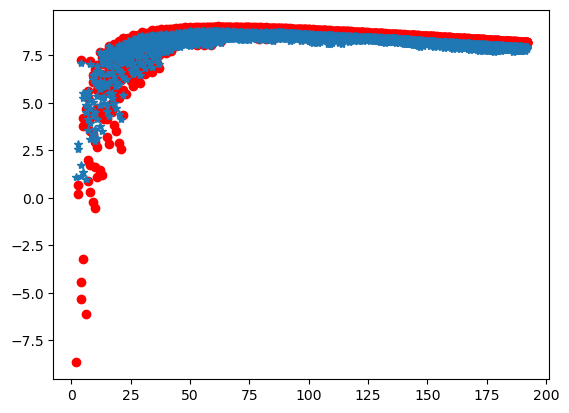

In [4]:
n_points = 2000
A = N +Z
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_th = 16
a_s_th = 18
a_c_th = 0.7
a_a_th = 24
a_p_th = 34

BE_th = model(a_v_th, a_s_th, a_c_th, a_a_th, a_p_th, N, Z)
plt.scatter(A[:n_points], BE_th[:n_points], color = 'red')

## EMCEE

In [14]:
# Parameters
param_names = ['a_v', 'a_s', 'a_c', 'a_a', 'a_p']

def loglikelihood(params):
    (a_v, a_s, a_c, a_a, a_p) = params
    log_like = -np.sum(((model(a_v, a_s, a_c, a_a, a_p, N, Z) - BE)/BE_err)**2 + np.log(2*np.pi*BE_err**2)) / 2. 
    return log_like
    
def prior(params):
    (a_v, a_s, a_c, a_a, a_p) = params

    if (
        0 < a_v < 50 and
        0 < a_s < 50 and
        0 < a_c < 3 and
        0 < a_a < 40 and
        0 < a_p < 50
    ):
        return 0

    return -np.inf

def log_post(params):
    if not np.isfinite(prior(params)):
        return -np.inf
    return loglikelihood(params) + prior(params)

In [15]:
ndim = 5
nwalkers = 30

p0 = np.array([0, 0, 0, 0, 0]) + np.random.rand(nwalkers, ndim) * np.array(
    [50, 50, 3, 40, 50]
)

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=())
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [02:54<00:00, 57.27it/s]


State([[12.35108146 10.15472404  0.29139423 22.00571151 10.82555491]
 [12.35108071 10.15472258  0.29139411 22.00571535 10.8255571 ]
 [12.35108021 10.15472181  0.29139404 22.00571483 10.82555676]
 [12.35108118 10.15472373  0.29139417 22.00571226 10.82555573]
 [12.35108051 10.15472223  0.29139406 22.0057142  10.8255556 ]
 [12.35107987 10.15472126  0.29139395 22.00571678 10.82555735]
 [12.35108094 10.15472305  0.29139413 22.00571336 10.82555568]
 [12.35107986 10.15472138  0.29139395 22.00571669 10.82555824]
 [12.3510807  10.15472253  0.2913941  22.00571368 10.82555714]
 [12.35108082 10.15472309  0.29139409 22.00571338 10.82555662]
 [12.35108144 10.154724    0.29139424 22.00570987 10.82555692]
 [12.35108043 10.15472227  0.29139405 22.00571471 10.82555754]
 [12.35108079 10.15472283  0.29139411 22.00571562 10.82555638]
 [12.35108096 10.1547232   0.29139416 22.00571139 10.82555554]
 [12.35107978 10.15472099  0.29139395 22.00571536 10.82555733]
 [12.35108086 10.15472304  0.29139415 22.0057117 

Text(0.5, 0, 'step number')

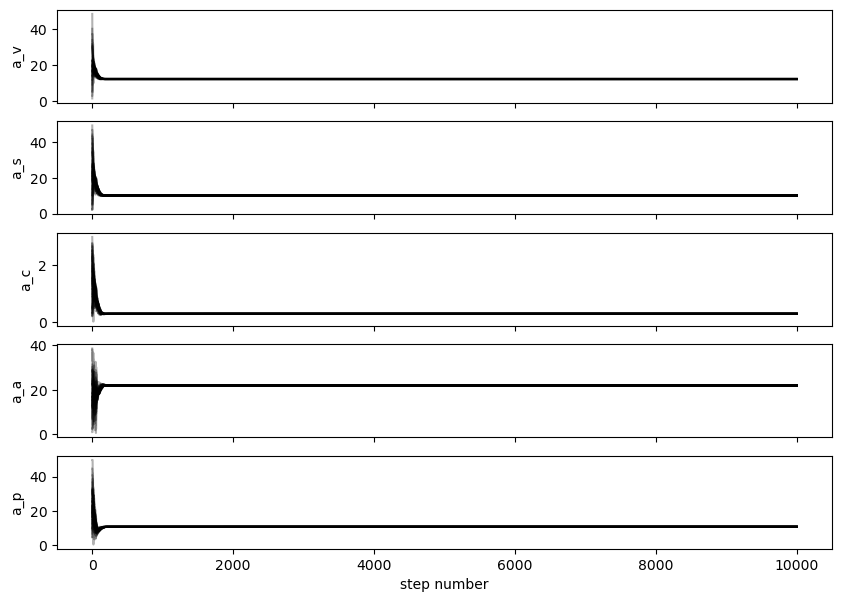

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for index, ax in enumerate(axs):
    ax.plot(samples[:, :, index], "k", alpha=0.3)
    ax.set_ylabel(["a_v", "a_s", "a_c", "a_a", "a_p"][index])

axs[-1].set_xlabel("step number")

Quantiles:
[(0.025, np.float64(12.351079858089816)), (0.5, np.float64(12.351080617547222)), (0.975, np.float64(12.351081349675805))]
Quantiles:
[(0.025, np.float64(10.15472121708178)), (0.5, np.float64(10.154722581722297)), (0.975, np.float64(10.154723897705297))]
Quantiles:
[(0.025, np.float64(0.29139394786093065)), (0.5, np.float64(0.2913940825323855)), (0.975, np.float64(0.2913942138222458))]
Quantiles:
[(0.025, np.float64(22.00571030122668)), (0.5, np.float64(22.0057137777467)), (0.975, np.float64(22.00571733890973))]
Quantiles:
[(0.025, np.float64(10.825554872133708)), (0.5, np.float64(10.825556476139415)), (0.975, np.float64(10.825558112278786))]


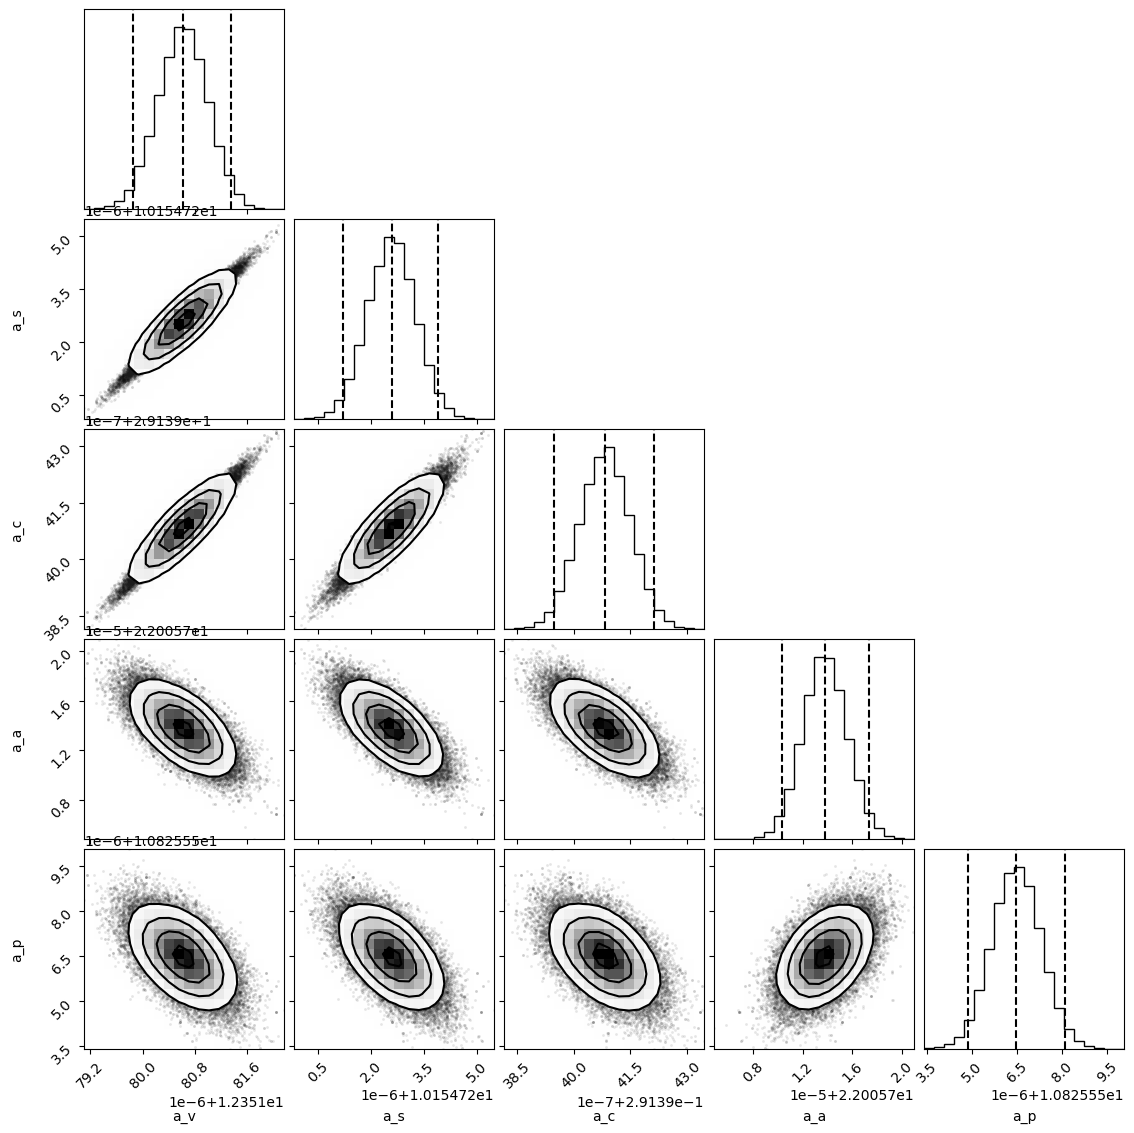

In [18]:
flat_samples = sampler.get_chain(discard=5000, thin=3, flat=True)
fig = corner.corner(flat_samples, labels=["a_v", "a_s", "a_c", "a_a", "a_p"], verbose= True, plot_contours=True, quantiles=[0.025, 0.5, 0.975], smooth=True)

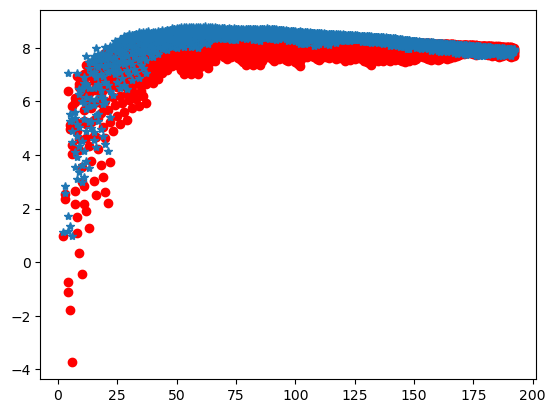

In [19]:
A = N + Z
n_points = 2000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_best = 12
a_s_best = 10
a_c_best = 0.3
a_a_best = 22
a_p_best = 10

BE_best = model(a_v_best, a_s_best, a_c_best, a_a_best, a_p_best, N, Z)
plt.scatter(A[:n_points], BE_best[:n_points], color = 'red')